## California Housing Prices Predictions

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn import preprocessing, model_selection, base, metrics, linear_model, pipeline, ensemble, svm, multiclass, neighbors, datasets, impute, compose, tree
from scipy import stats
import seaborn as sns

### Exploratory Data Analysis

In [2]:
housing = pd.read_csv('data/housing.csv')
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


**Sorting by population**

In [3]:
housing.sort_values(by='population', ascending=False).head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
15360,-117.42,33.35,14.0,25135.0,4819.0,35682.0,4769.0,2.5729,134400.0,<1H OCEAN
9880,-121.79,36.64,11.0,32627.0,6445.0,28566.0,6082.0,2.3087,118800.0,<1H OCEAN
13139,-121.44,38.43,3.0,39320.0,6210.0,16305.0,5358.0,4.9516,153700.0,INLAND
10309,-117.74,33.89,4.0,37937.0,5471.0,16122.0,5189.0,7.4947,366300.0,<1H OCEAN
6057,-117.78,34.03,8.0,32054.0,5290.0,15507.0,5050.0,6.0191,253900.0,<1H OCEAN
6066,-117.87,34.04,7.0,27700.0,4179.0,15037.0,4072.0,6.6288,339700.0,<1H OCEAN
12215,-117.12,33.52,4.0,30401.0,4957.0,13251.0,4339.0,4.5841,212300.0,<1H OCEAN
9019,-118.78,34.16,9.0,30405.0,4093.0,12873.0,3931.0,8.0137,399200.0,NEAR OCEAN
17413,-120.59,34.70,29.0,17738.0,3114.0,12427.0,2826.0,2.7377,28300.0,NEAR OCEAN
922,-121.92,37.53,7.0,28258.0,3864.0,12203.0,3701.0,8.4045,451100.0,<1H OCEAN


**Train-test Split**

In [10]:
X = housing.drop('median_house_value', axis=1)
y = housing['median_house_value']

# X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

**Problems with Random Split**

In [11]:
X.value_counts(subset=X['ocean_proximity'])

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='ocean_proximity', ylabel='Count'>

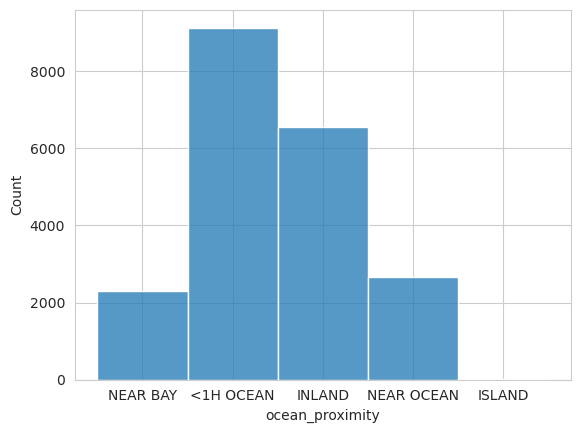

In [16]:
sns.histplot(data=X, x='ocean_proximity')

**Stratified Shuffling**

In [4]:
# X = housing.drop('median_house_value', axis=1)
# y = housing['median_house_value']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=X['ocean_proximity'])

In [25]:
len_1H_train = len(X_train[X_train['ocean_proximity']=='<1H OCEAN'])/len(X_train)
len_1H_test = len(X_test[X_test['ocean_proximity']=='<1H OCEAN'])/len(X_test)
len_1H_test, len_1H_train

(0.44263565891472867, 0.44263565891472867)

### Visualizing Your Data

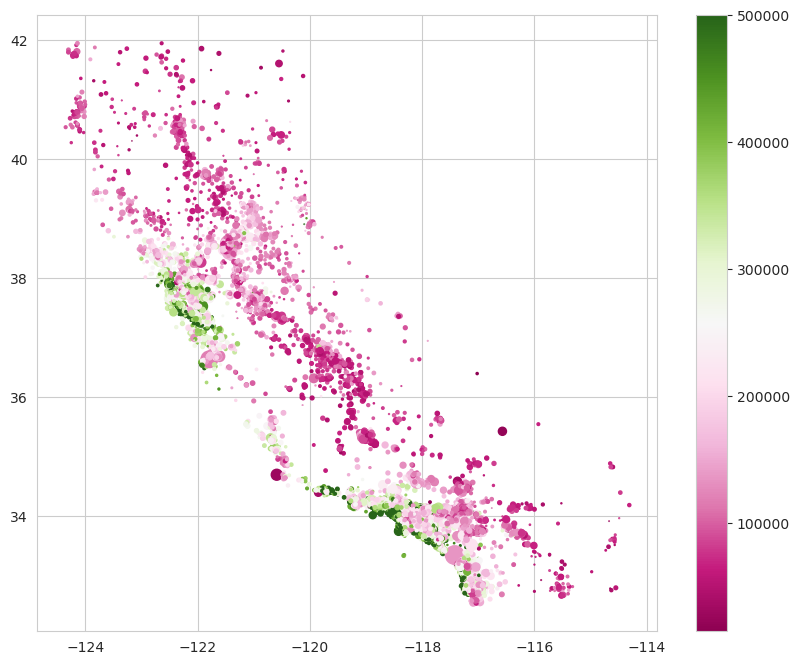

In [42]:
plt.figure(figsize=(10,8))
scatter = plt.scatter(X_train['longitude'], X_train['latitude'], s=(X_train['population']/200), c=y_train, cmap='PiYG')
plt.colorbar(scatter)

In [6]:
y_train[X_train['ocean_proximity']=='<1H OCEAN'].sort_values(ascending=False)

10801    500001.0
8581     500001.0
5244     500001.0
10742    500001.0
8854     500001.0
           ...   
11534     46700.0
11219     45000.0
12217     43000.0
4873      38800.0
2598      36700.0
Name: median_house_value, Length: 6860, dtype: float64

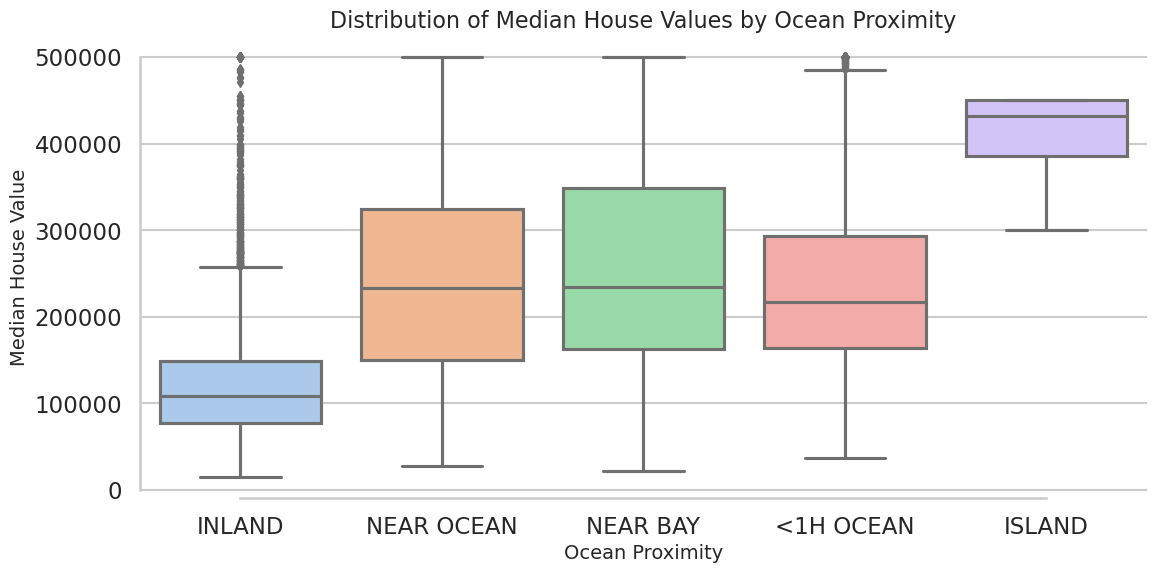

In [55]:
sns.set_style("whitegrid")
sns.set_context("talk")  # can try 'paper' and 'notebook' as well
plt.figure(figsize=(13, 6))
sns.boxplot(data=pd.concat([X_train, y_train], axis=1), x='ocean_proximity', y='median_house_value', palette='pastel')  # palette values to try: 'coolwarm', 'bright', 'dark'
sns.despine(trim=True)

plt.xlabel('Ocean Proximity', fontsize=14)
plt.ylabel('Median House Value', fontsize=14)
plt.title('Distribution of Median House Values by Ocean Proximity', fontsize=16)

plt.show()

### Feature Engineering
**Highlight Major Cities**

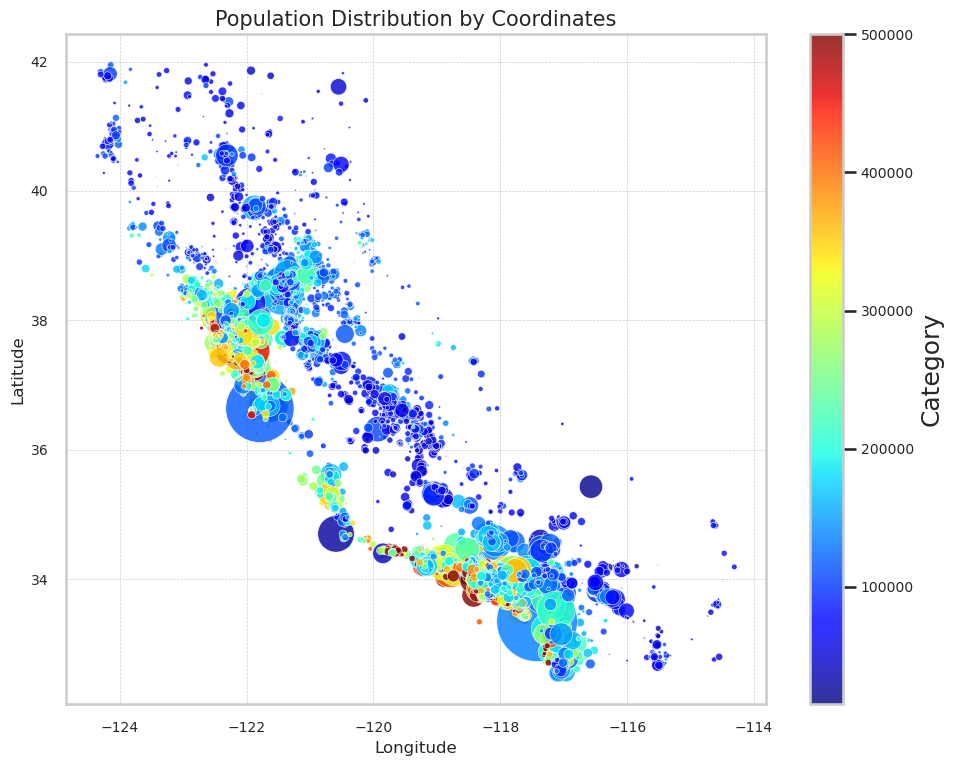

In [73]:
plt.figure(figsize=(10, 8))
plt.scatter(X_train['longitude'], X_train['latitude'], s=(X_train['population']**1.5/2000), c=y_train, cmap='jet', alpha=0.8, edgecolor='w', linewidth=0.5)
plt.title('Population Distribution by Coordinates', fontsize=15)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)
plt.colorbar(label='Category').ax.tick_params(labelsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()

**Create a New Feature - Distance From Closest Major City**

In [74]:
major_cities = X_train[['longitude', 'latitude', 'population']].sort_values(by='population', ascending=False).head(10)
major_cities

,longitude,latitude,population
15360,-117.42,33.35,35682.0
9880,-121.79,36.64,28566.0
13139,-121.44,38.43,16305.0
6057,-117.78,34.03,15507.0
6066,-117.87,34.04,15037.0
12215,-117.12,33.52,13251.0
9019,-118.78,34.16,12873.0
17413,-120.59,34.70,12427.0
922,-121.92,37.53,12203.0
9744,-121.68,36.72,12153.0


In [77]:
def distance(row):
    x1, y1 = row['longitude'], row['latitude']
    dists = []
    for x2, y2 in zip(major_cities['longitude'], major_cities['latitude']):
        cur_dis = np.sqrt((x2-x1)**2+(y2-y1)**2)
        dists.append(cur_dis)
    return min(dists)

distance_from_city = X_train.apply(distance, axis=1)
distance_from_city

5952     0.082462
2130     1.971624
14163    0.682642
1417     0.475395
8771     0.527731
           ...   
4534     0.340147
4665     0.430116
19307    1.204159
18559    0.418688
6241     0.101980
Length: 15480, dtype: float64

In [79]:
# distance_from_city_bad = []
# 
# for i in range(len(X_train)):
#     x1, y1 = X_train.iloc[i]['longitude'], X_train.iloc[i]['latitude']
#     dists = []
#     for j in range(len(major_cities)):
#         x2, y2 = major_cities.iloc[j]['longitude'], major_cities.iloc[j]['latitude']
#         cur_dis = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
#         dists.append(cur_dis)
#     distance_from_city_bad.append(min(dists))
# 
# distance_from_city_bad = pd.Series(distance_from_city_bad)

**Pearson Correlation**

In [83]:
stats.pearsonr(distance_from_city, y_train)[0]

-0.36406441914976356

In [81]:
X_train_num = X_train.drop('ocean_proximity', axis=1)
temp_df = pd.concat([X_train_num, y_train, pd.Series(distance_from_city, name='distance_from_city')], axis=1)
temp_df.corr()['median_house_value'].abs().sort_values()

population            0.026461
longitude             0.039905
total_bedrooms        0.050114
households            0.065317
housing_median_age    0.103710
total_rooms           0.132939
latitude              0.151120
distance_from_city    0.364064
median_income         0.683593
median_house_value    1.000000
Name: median_house_value, dtype: float64

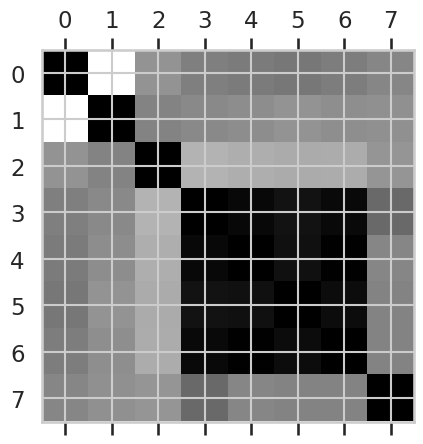

In [84]:
plt.matshow(X_train_num.corr().values, cmap='binary')

**Getting Rid of Highly Inter-Correlated Attributes**
**Constructing New Features -**
1. **Bedrooms per Room**
2. **People per House**

In [14]:
X_train_num.iloc[:, [3,4,5,6, -2]].corr().median(axis=1)

total_rooms       0.920322
total_bedrooms    0.980270
population        0.907422
households        0.980270
households        0.980270
dtype: float64

In [15]:
def extract_bedrooms(housing_data):
    bedrooms_per_room = housing_data['total_bedrooms']/housing_data['total_rooms']
    return bedrooms_per_room.fillna(bedrooms_per_room.median())

def extract_house_pop(housing_data):
    pop_per_house = housing_data['population']/housing_data['households']
    return pop_per_house.fillna(max(pop_per_house))

bedrooms_per_room = extract_bedrooms(X_train)
pop_per_house = extract_house_pop(X_train)
pop_per_house

8158     2.529412
18368    2.404523
19197    2.235849
3746     2.272549
13073    2.088757
           ...   
11284    3.032258
11964    3.904232
5390     3.332068
860      3.178891
15795    2.108696
Length: 15480, dtype: float64

In [16]:
stats.pearsonr(pop_per_house, y_train)

PearsonRResult(statistic=-0.021421937395641147, pvalue=0.007690157968935672)

In [17]:
stats.pearsonr(bedrooms_per_room, y_train)

PearsonRResult(statistic=-0.2520212805438078, pvalue=7.097385402374278e-223)

In [85]:
X_train.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        162
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

### Preprocessing

 1. A transformer adding engineered features
2. SimpleImputer for missing values, i.e. for `total_bedrooms`
3. OneHotEncoding for `ocean_proximity`
4. StandardScaler for whole dataset
 _____________________________________________________________________________________________________________________________________
**Method 1 - Custom Transformer**

In [86]:
class AttribsAdder(base.BaseEstimator, base.TransformerMixin):
    def __init__(self, add_bpr=True, add_distance=True, n_cities=20, remove_bedrooms=False):
        self.feature_names_out_ = None
        self.feature_names_in_ = None
        self.add_bpr = add_bpr
        self.add_distance = add_distance
        self.remove_bedrooms = remove_bedrooms
        self.n_cities = n_cities
        
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.tolist() if isinstance(X, pd.DataFrame) else None
        return self
    
    def transform(self, X, y=None):
        X_transformed = X.copy()
        if self.add_bpr:
            X_transformed['bedrooms_per_room'] = self.extract_bedrooms(X)
        if self.add_distance:
            major_cities = X_transformed[['longitude', 'latitude', 'population']].sort_values(by='population', ascending=False).head(self.n_cities)
            X['distance_from_city'] = X_transformed.apply(self.distance, cities=major_cities, axis=1)
        if self.remove_bedrooms:
            X.drop('total_bedrooms', axis=1, inplace=True)
        self.feature_names_out_ = X.columns
        return X_transformed.values
    
    def get_feature_names_out(self, X):
        return self.feature_names_out_
    
    @staticmethod
    def distance(row, cities=None):
        x1, y1 = row['longitude'], row['latitude']
        dists = []
        for x2, y2 in zip(cities['longitude'], cities['latitude']):
            cur_dis = np.sqrt((x2-x1)**2+(y2-y1)**2)
            dists.append(cur_dis)
        return min(dists)
    
    @staticmethod
    def extract_bedrooms(housing_data):
        bedrooms_per_room = housing_data['total_bedrooms']/housing_data['total_rooms']
        return bedrooms_per_room.fillna(bedrooms_per_room.median())


**Method 2 - Custom Transformer the Easy Way**

In [91]:
def transform_data(X, add_bpr=True, add_distance=True, n_cities=20, remove_bedrooms=False):
    X_transformed = X.copy()

    # Add bedrooms per room feature
    if add_bpr:
        X_transformed['bedrooms_per_room'] = X_transformed['total_bedrooms'] / X_transformed['total_rooms']
        X_transformed['bedrooms_per_room'].fillna(X_transformed['bedrooms_per_room'].median(), inplace=True)

    # Add distance from major cities feature
    if add_distance:
        major_cities = X_transformed[['longitude', 'latitude', 'population']].sort_values(by='population', ascending=False).head(n_cities)
        X_transformed['distance_from_city'] = X_transformed.apply(lambda row: min_distance(row, major_cities), axis=1)

    # Optionally remove the total_bedrooms column
    if remove_bedrooms:
        X_transformed.drop('total_bedrooms', axis=1, inplace=True)

    return X_transformed

def min_distance(row, cities):
    x1, y1 = row['longitude'], row['latitude']
    return min(np.sqrt((cities['longitude'] - x1) ** 2 + (cities['latitude'] - y1) ** 2))

attribs_adder = preprocessing.FunctionTransformer(transform_data, kw_args={'add_bpr': True, 'add_distance': True, 'n_cities': 20, 'remove_bedrooms': False})

# transformed_X = attribs_adder.fit_transform(X)

**Method 3 - Eww.. Chhii**

In [94]:
X_train_transformed = X_train.copy()

X_train_transformed['bedrooms_per_room'] = X_train['total_bedrooms'] / X_train['total_rooms']
X_train_transformed['bedrooms_per_room'].fillna(X_train_transformed['bedrooms_per_room'].median(), inplace=True)

X_train_transformed.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,bedrooms_per_room
5952,-117.85,34.12,30.0,4367.0,1033.0,2524.0,954.0,3.0448,INLAND,0.236547
2130,-119.71,36.80,17.0,2056.0,366.0,1259.0,367.0,3.9338,INLAND,0.178016
14163,-117.06,32.77,18.0,2269.0,682.0,1329.0,581.0,1.7951,NEAR OCEAN,0.300573


In [100]:
X_train_transformed['distance_from_city'] = distance_from_city
X_train_transformed.drop('total_bedrooms', axis=1, inplace=True)
X_train_transformed.head(3)

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity,bedrooms_per_room,distance_from_city
5952,-117.85,34.12,30.0,4367.0,2524.0,954.0,3.0448,INLAND,0.236547,0.082462
2130,-119.71,36.80,17.0,2056.0,1259.0,367.0,3.9338,INLAND,0.178016,1.971624
14163,-117.06,32.77,18.0,2269.0,1329.0,581.0,1.7951,NEAR OCEAN,0.300573,0.682642


In [101]:
num_X_train = X_train_transformed.drop(['ocean_proximity'], axis=1)
cat_X_train = X_train_transformed['ocean_proximity']

**Scaling - Standardizing and Normalizing**

In [106]:
scaler = preprocessing.StandardScaler()
scaled_num_X_train = scaler.fit_transform(num_X_train)
scaled_num_X_train[:3]

array([[ 0.86523359, -0.71201939,  0.10258007,  0.80917541,  0.97087038,
         1.21162176, -0.4362123 ,  0.4083842 , -0.90865146],
       [-0.06416278,  0.54059367, -0.93268639, -0.26118502, -0.1420445 ,
        -0.34520709,  0.03348298, -0.60852525,  2.40237969],
       [ 1.25997721, -1.34299984, -0.85305051, -0.16253215, -0.08046028,
         0.22235914, -1.09648024,  1.52075994,  0.14325118]])

**Encoding**

In [114]:
encoder = preprocessing.OneHotEncoder()
encoded_cat_X_train = encoder.fit_transform(cat_X_train.values.reshape(-1, 1))
encoded_cat_X_train[:3].toarray()

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

**Imputer**

In [122]:
test_data = X_train['total_bedrooms']
test_data.isna().sum()

162

In [123]:
imputer = impute.SimpleImputer(strategy='mean')
test_data = imputer.fit_transform(test_data.values.reshape(-1, 1))
np.isnan(test_data).sum()

0

**_________________________________________________________________________________________________________________________________________________________________________________________________**

In [124]:
num_cols = X_train.columns[:-1].tolist()
cat_cols = [X_train.columns[-1]]
num_cols, cat_cols

(['longitude',
  'latitude',
  'housing_median_age',
  'total_rooms',
  'total_bedrooms',
  'population',
  'households',
  'median_income'],
 ['ocean_proximity'])

### Pipelines

In [125]:
num_pipeline = pipeline.Pipeline([('attrib_adder', AttribsAdder()),
                                  ('imputer', impute.SimpleImputer(strategy='median')),
                                  ('scaler', preprocessing.StandardScaler())])


full_transformation_pipeline = compose.ColumnTransformer([('num_pipe', num_pipeline, num_cols),
                                                          ('one_hot', preprocessing.OneHotEncoder(), cat_cols)])

In [126]:
X_train_prep = full_transformation_pipeline.fit_transform(X_train)
X_train_prep[:10]

array([[ 0.86523359, -0.71201939,  0.10258007,  0.80917541,  1.20907015,
         0.97087038,  1.21162176, -0.4362123 ,  0.4083842 ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [-0.06416278,  0.54059367, -0.93268639, -0.26118502, -0.40566927,
        -0.1420445 , -0.34520709,  0.03348298, -0.60852525,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ],
       [ 1.25997721, -1.34299984, -0.85305051, -0.16253215,  0.35933471,
        -0.08046028,  0.22235914, -1.09648024,  1.52075994,  0.        ,
         0.        ,  0.        ,  0.        ,  1.        ],
       [-1.22840663,  1.09679126,  0.26185183, -0.51684878, -0.61628746,
        -0.59072955, -0.61042495, -0.35421376, -0.47839988,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ],
       [ 0.62039261, -0.86158512,  0.4211236 , -0.41217485, -0.25799445,
        -0.36286793, -0.27625045,  0.03718137,  0.58688211,  1.        ,
         0.        ,  0.  

In [127]:
full_transformation_pipeline.get_feature_names_out().tolist()

['num_pipe__longitude',
 'num_pipe__latitude',
 'num_pipe__housing_median_age',
 'num_pipe__total_rooms',
 'num_pipe__total_bedrooms',
 'num_pipe__population',
 'num_pipe__households',
 'num_pipe__median_income',
 'num_pipe__distance_from_city',
 'one_hot__ocean_proximity_<1H OCEAN',
 'one_hot__ocean_proximity_INLAND',
 'one_hot__ocean_proximity_ISLAND',
 'one_hot__ocean_proximity_NEAR BAY',
 'one_hot__ocean_proximity_NEAR OCEAN']

**Saving Progress**

In [11]:
joblib.dump(full_transformation_pipeline, 'saved_models/transformation_pipeline.pkl')

['saved_models/transformation_pipeline.pkl']

### Modelling and Inference

**Validation Set and Initial Setup**

In [139]:
X_train_new, X_val, y_train_new, y_val = model_selection.train_test_split(X_train_prep, y_train, test_size=0.2)

def errors(model, X_train=X_train_new, X_val=X_val, y_train=y_train_new, y_val=y_val):
    model.fit(X_train, y_train)
    y_preds_train = model.predict(X_train)
    y_preds_val = model.predict(X_val)

    print('{0} train error: {1}'.format(model, np.sqrt(metrics.mean_squared_error(y_train, y_preds_train))))
    print('{0} val error: {1}'.format(model, np.sqrt(metrics.mean_squared_error(y_val, y_preds_val))))

In [154]:
def plot_errors(models, X_train=X_train_new, y_train=y_train_new, X_val=X_val, y_val=y_val):
    train_errors, val_errors, model_names = [], [], []

    for model in models:
        model.fit(X_train, y_train)
        y_preds_train, y_preds_val = model.predict(X_train), model.predict(X_val)
        train_errors.append(np.sqrt(metrics.mean_squared_error(y_train, y_preds_train)))
        val_errors.append(np.sqrt(metrics.mean_squared_error(y_val, y_preds_val)))
        model_names.append(type(model).__name__)

    x, width = np.arange(len(models)), 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width / 2, train_errors, width, label='Train Error', color='skyblue', edgecolor='black')
    ax.bar(x + width / 2, val_errors, width, label='Validation Error', color='salmon', edgecolor='black')

    ax.set_ylabel('RMSE', fontsize=10)
    ax.set_title('Training and Validation Error by Model', fontsize=12)
    ax.set_xticks(x)
    ax.set_xticklabels(model_names, rotation=45, ha='right', fontsize=8)
    ax.tick_params(axis='y', labelsize=8)
    ax.legend(fontsize=8)
    ax.set_facecolor('#f0f0f0')  # Light grey background for main graph area
    fig.tight_layout()
    plt.show()

**Linear Regression**

In [140]:
lr = linear_model.LinearRegression()

errors(lr)

LinearRegression() train error: 68323.79910534195
LinearRegression() val error: 68072.11108159834


In [150]:
poly_features = preprocessing.PolynomialFeatures(degree=2)
X_temp = poly_features.fit_transform(X_train_new)
X_temp_val = poly_features.fit_transform(X_val)

lr2 = linear_model.LinearRegression()

errors(lr2, X_temp, X_temp_val)

LinearRegression() train error: 60173.36241857854
LinearRegression() val error: 65040.47321399018


**Initial Run**

/home/crow/miniconda3/envs/small-projects-ml/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


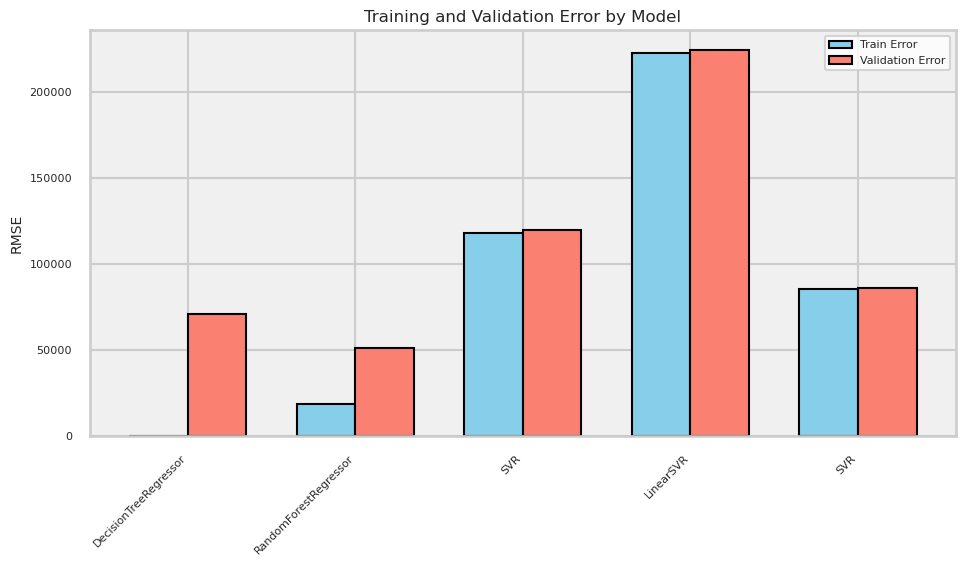

In [155]:
#rough cell

models = [tree.DecisionTreeRegressor(), ensemble.RandomForestRegressor(), svm.SVR(), svm.LinearSVR(), svm.SVR(kernel='linear', C=10)]

plot_errors(models)

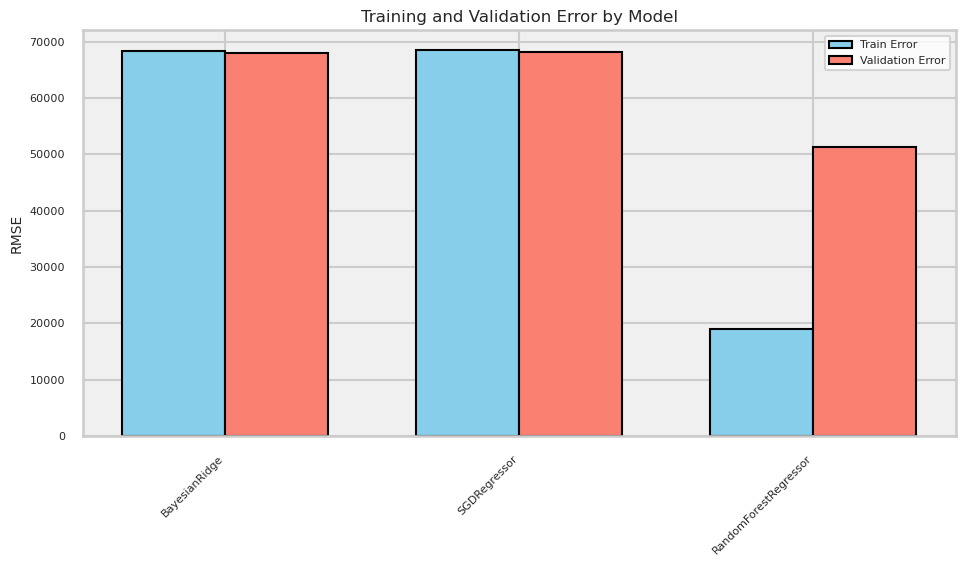

In [156]:
models_2 = [linear_model.BayesianRidge(), linear_model.SGDRegressor(), ensemble.RandomForestRegressor(n_estimators=50, max_features=8)]

plot_errors(models_2)

### Hyperparameter Tuning
**Cross-Validation**

In [162]:
rf = ensemble.RandomForestRegressor(n_estimators=50, max_features=8)

cross_val_scores = model_selection.cross_val_score(rf, X_train_prep, y_train, cv=4, n_jobs=-1, scoring='neg_mean_squared_error')

np.sqrt(np.abs(cross_val_scores))

array([50628.79347838, 49311.60797315, 48898.36980771, 52747.16105697])

**Grid Search**

In [210]:
param_grid = [
    {
        'bootstrap': [True],
        'n_estimators': [40, 50, 60],  
        'max_features': [6, 8, 10],  
        'max_depth': [None, 25, 30],  
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2]
    },
    {
        'bootstrap': [False],
        'n_estimators': [45, 50, 55],
        'max_features': [7, 8, 9],
        'max_depth': [20, 25, 30],  
        'min_samples_split': [2, 3],
        'min_samples_leaf': [1, 2]
    }
]

In [211]:
# !!!RUN WITH CAUTION, MIGHT TAKE 45+ MINUTES DEPENDING ON YOUR MACHINE
# REFERENCE: TOOK 2+ MINUTES ON MY i9-14900K 64GB RAM USING ALL CPUs
grid_search = model_selection.GridSearchCV(rf, param_grid, scoring='neg_mean_squared_error', cv=4, n_jobs=-1, refit=True, return_train_score=True)

grid_search.fit(X_train_prep, y_train)

GridSearchCV(cv=4,
             estimator=RandomForestRegressor(max_features=8, n_estimators=50),
             n_jobs=-1,
             param_grid=[{'bootstrap': [True], 'max_depth': [None, 25, 30],
                          'max_features': [6, 8, 10],
                          'min_samples_leaf': [1, 2],
                          'min_samples_split': [2, 3],
                          'n_estimators': [40, 50, 60]},
                         {'bootstrap': [False], 'max_depth': [20, 25, 30],
                          'max_features': [7, 8, 9], 'min_samples_leaf': [1, 2],
                          'min_samples_split': [2, 3],
                          'n_estimators': [45, 50, 55]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [249]:
def display_top_grid_search_results(grid_search):
    results = pd.DataFrame(grid_search.cv_results_)
    top_results = results.nlargest(10, 'mean_test_score')
    top_results = top_results[['mean_test_score','mean_train_score', 'params']]
    top_results['mean_test_score'] = np.sqrt(np.abs(top_results['mean_test_score'].round(2)))
    top_results['mean_train_score'] = np.sqrt(np.abs(top_results['mean_train_score'].round(2)))
    top_results.reset_index(drop=True, inplace=True)
    return top_results

In [246]:
display_top_grid_search_results(grid_search)

,mean_test_score,mean_train_score,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators
0,49429.068065,10151.111728,False,30,8,2,3,50
1,49489.176045,10059.078779,False,25,8,2,3,55
2,49515.533283,10401.033408,False,25,7,2,2,55
3,49519.472888,11126.158752,False,20,7,2,2,50
4,49542.663420,10822.968763,False,20,8,2,3,55
5,49557.407891,10859.326416,False,20,8,2,2,55
6,49563.705674,10138.524217,False,30,8,2,2,55
7,49571.540413,10433.122840,False,30,7,2,3,55
8,49587.074741,66.537433,False,30,7,1,2,55
9,49611.013134,10160.328724,False,30,8,2,3,55


**Randomized Search**

In [247]:
param_distribs = {
    'n_estimators': stats.randint(low=1, high=200),
    'max_features': stats.randint(low=1, high=8)
}

rf2 = ensemble.RandomForestRegressor(random_state=42)
rnd_search = model_selection.RandomizedSearchCV(rf2, param_distributions=param_distribs,
                                n_iter=15, cv=5, scoring='neg_mean_squared_error', random_state=42, return_train_score=True)

rnd_search.fit(X_train_prep, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=15,
                   param_distributions={'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f76709d5650>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f767092e3d0>},
                   random_state=42, return_train_score=True,
                   scoring='neg_mean_squared_error')

In [250]:
display_top_grid_search_results(rnd_search)

,mean_test_score,mean_train_score,params
0,49796.343591,18408.104371,"{'max_features': 7, 'n_estimators': 180}"
1,49904.941855,18536.086112,"{'max_features': 7, 'n_estimators': 122}"
2,49944.577399,18570.547011,"{'max_features': 6, 'n_estimators': 130}"
3,50166.678841,18795.755019,"{'max_features': 6, 'n_estimators': 89}"
4,50336.083171,18777.385023,"{'max_features': 5, 'n_estimators': 100}"
5,50578.860735,18732.661394,"{'max_features': 4, 'n_estimators': 158}"
6,51102.798631,18929.012233,"{'max_features': 3, 'n_estimators': 150}"
7,51218.499263,19143.228578,"{'max_features': 3, 'n_estimators': 88}"
8,51287.759946,19283.466972,"{'max_features': 3, 'n_estimators': 72}"
9,51334.431511,19280.924064,"{'max_features': 3, 'n_estimators': 75}"


### Evaluating on Test

In [225]:
np.sqrt(np.abs(rnd_search.best_score_))

49796.3435907424

In [234]:
rf_best = rnd_search.best_estimator_
rf_best.fit(X_train_prep, y_train)

RandomForestRegressor(max_features=7, n_estimators=180, random_state=42)

In [235]:
X_test_prep = full_transformation_pipeline.transform(X_test)

rf_preds = rf_best.predict(X_test_prep)
np.sqrt(metrics.mean_squared_error(y_test, rf_preds))

48317.96401807696

For more such projects, visit [my Github](https://www.github.com/ryuukkk)